# Big drop filter 
### This notebook is third in the series of soiling detection pipeline notebooks

Data from other parks can be used in the following notebooks by changing the working_dir and filepaths <b>
    
CSVs imported in this notebook are created in the 2_detect_timewindow pipeline notebook <b>

   
 Author: Lisa Crowther

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import copy
import matplotlib.pyplot as plt
from pathlib import Path

import datetime
from datetime import datetime

## Import dataframes from previous notebook


In [2]:
working_dir = "../data/temp/park2/"


In [3]:
root_path = "../data/temp/park2/time_mask_filter/"
EPI_stringfilt_path = root_path + "EPI_stringfilt.csv"
EPI_timemask_path = root_path + "EPI_timemask.csv"

In [4]:
def read_data(EPI_stringfilt_path, EPI_timemask_path):
    EPI_stringfilt = pd.read_csv(EPI_stringfilt_path, delimiter=',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
    EPI_timemask = pd.read_csv(EPI_timemask_path, delimiter = ',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
    return [EPI_stringfilt, EPI_timemask]

In [5]:
EPI_stringfilt, EPI_timemask = read_data(EPI_stringfilt_path, EPI_timemask_path)

## Filter by the change in EPI from one day to the next


### Aggregate by day and calculate the daily change in EPI

In [7]:
EPI_timemask_D= EPI_timemask.resample(rule='D').mean()

In [8]:
lagdf_D = pd.DataFrame(copy.deepcopy(EPI_timemask_D))
for cols in lagdf_D.columns:
    lagdf_D[cols]=lagdf_D[cols]- lagdf_D[cols].shift(1)
    


In [9]:
leaddf_D = pd.DataFrame(copy.deepcopy(lagdf_D))
for cols in leaddf_D.columns:
    leaddf_D[cols]= leaddf_D[cols]-leaddf_D[cols].shift(-1)


### Set thresholds for large drops/jumps

In [10]:
description_dailyagg = lagdf_D.describe()
mean_lag= description_dailyagg.loc['mean'].mean()
std_lag= description_dailyagg.loc['std'].mean()

lower_thresh_lag = mean_lag-std_lag
upper_thresh_lag = -lower_thresh_lag
lower_thresh_lag

-0.06511487704247261

In [11]:
description_dailyagg = leaddf_D.describe()
mean_lead= description_dailyagg.loc['mean'].mean()
std_lead= description_dailyagg.loc['std'].mean()

lower_thresh_lead = mean_lag-std_lag
upper_thresh_lead = -lower_thresh_lag
lower_thresh_lead

-0.06511487704247261

###  Create boolean masks for removing big drops/jumps
Also generates a mask for only removing big drops (drop_mask), if wanted

In [12]:

bool_1=lagdf_D.lt(lower_thresh_lag)
bool_2 =lagdf_D.gt(upper_thresh_lag)

bool_3=leaddf_D.lt(lower_thresh_lead)
bool_4 =leaddf_D.gt(upper_thresh_lead)


#if only using the drop filter
drop_mask=bool_1|bool_2
#if use the drop and jump filter: stringmask2
drop_jump_mask=bool_1|bool_2|bool_3|bool_4



In [13]:

EPI_bigdrop_filt = EPI_timemask_D.mask(drop_jump_mask)



Visualise to check effect of filter

<AxesSubplot:xlabel='datetime'>

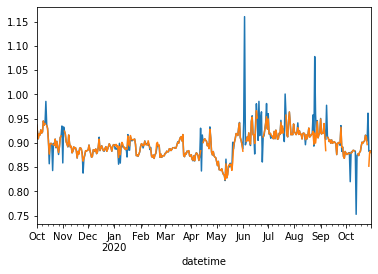

In [104]:

EPI_timemask_D.median(axis=1).plot()
EPI_bigdrop_filt.median(axis=1).plot()

### Save big-drop filtered EPIs, and the masks for filtering

In [105]:
##save data function from Marcus's scripts
def save_data(dataframes, names, root_dir, sub_dir):

    if root_dir[-1] != "/":
                root_dir += "/"

    if sub_dir[-1] != "/":
                root_dir += sub_dir + "/"

    for data, name in zip(dataframes, names):
        try:
            filepath_out = root_dir + name + ".csv"
            Path(root_dir).mkdir(parents=True, exist_ok=True)
            print(f"\tSaving {filepath_out}...")
            data.to_csv(filepath_out)
            print("\tDone.")
        except Exception as e:
            print(e)
            pass

In [106]:

save_data([EPI_bigdrop_filt,drop_jump_mask,drop_mask], ["EPI_bigdrop_filt",'drop_jump_mask','drop_mask'], working_dir, "big_drop_filter")

	Saving ../data/temp/park2/big_drop_filter/EPI_bigdrop_filt.csv...
	Done.
	Saving ../data/temp/park2/big_drop_filter/drop_jump_mask.csv...
	Done.
	Saving ../data/temp/park2/big_drop_filter/drop_mask.csv...
	Done.
